In [49]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


IMAGE_PATH = 'images/objects/smartphones.jpg'

FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.9
THICKNESS = 1

BLACK  = (0,0,0)
BLUE   = (255,178,50)
YELLOW = (0,255,255)


def cv2_imshow(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)


def draw_label(im, label, x, y):
    """Draw text onto image at location."""
    # Get text size.
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]
    # Use text size to create a BLACK rectangle.
    cv2.rectangle(im, (x,y), (x + dim[0], y + dim[1] + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle.
    cv2.putText(im, label, (x, y + dim[1]), FONT_FACE, FONT_SCALE, YELLOW, THICKNESS, cv2.LINE_AA)


def get_coco_classes(path):
    with open(path, 'rt') as f:
        return f.read().rstrip('\n').split('\n')
        
img = cv2.imread(IMAGE_PATH)

model = 'models/yolo/yolov7.onnx'
net = cv2.dnn.readNetFromONNX(model)
blob = cv2.dnn.blobFromImage(img, 1/255, (640, 640))
net.setInput(blob)

output = net.forward()
print(output.shape)

(1, 3, 20, 20, 85)


cat 0.063173786 2.3057485 0.013553437 1.8171942 [0 2 0 3]
cat 0.053294763 -0.31949443 0.024510548 1.8607147 [ 0 -2  0  3]
cat 0.2430097 1.5286719 0.86175 1.8558478 [0 1 1 3]
cat 1.075073 0.074531615 -0.105857566 1.1535463 [2 0 0 2]
cat -1.110591 0.054662675 -0.10303513 1.1433159 [-1  0  0  2]
cat 0.24851198 -0.582363 0.8637903 1.9024944 [ 0 -2  1  3]
cat 0.06510401 2.303114 -0.2692418 0.32010102 [0 4 0 0]
cat 0.05691707 -0.3254102 -0.25950235 0.33122605 [0 0 0 0]
cat 0.2435187 1.5133778 0.4258566 0.33059984 [0 2 0 0]
cat 1.0735848 0.061039984 -0.37565 0.044250682 [2 0 0 0]
cat -1.111124 0.053631872 -0.37331086 0.03984344 [-1  0  0  0]
cat 0.24651319 -0.5837761 0.4268728 0.3440858 [ 0 -1  0  0]
cat 0.07053033 2.3003645 -0.9434505 -0.1977702 [ 1  4 -1  0]
cat 0.0639374 -0.32973897 -0.93143004 -0.18754266 [ 0  0 -1  0]
cat 0.24191935 1.5164139 -0.440952 -0.18929939 [0 3 0 0]
cat 1.0806994 0.055806577 -1.0282962 -0.41454247 [ 2  0 -1  0]
cat 0.24690135 -0.5841877 -0.44057798 -0.17950156 [0

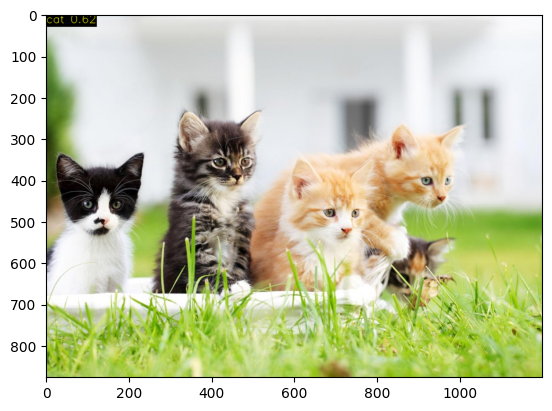

In [50]:
INPUT_WIDTH = INPUT_HEIGHT = 640

CX = 0
CY = 1
W = 2
H = 3
CONFIDENCE = 4


THRESHOLD_CONFIDENCE = 0.40
THRESHOLD_SCORE = 0.5
THRESHOLD_NMS = 0.50

h, w, _ = img.shape

x_factor = w / INPUT_WIDTH
y_factor = w / INPUT_HEIGHT

class_ids = list()
confidences = list()
selected_bboxes = list()

classes = get_coco_classes("models/coco.names")

bboxes = output[0]

for i in bboxes:
    for j in i:
        for bbox in j:
            
            if bbox[CONFIDENCE] < THRESHOLD_CONFIDENCE:
                continue

            classes_score = bbox[CONFIDENCE+1:]
            class_id = np.argmax(classes_score)
            # print(classes[class_id])
            if classes_score[class_id] < THRESHOLD_SCORE:
                continue
            
            confidences.append(bbox[CONFIDENCE])
            class_ids.append(class_id)
            
            cx, cy, w, h = bbox[CX], bbox[CY], bbox[W], bbox[H]
            
            left = int((cx - w/2) * x_factor)
            top = int((cy - h/2) * y_factor)
            width = int(w * x_factor)
            height = int(h * y_factor)
            box = np.array([left, top, width, height])
            print(classes[class_id], cx, cy, w, h, box)
            selected_bboxes.append(box)

indices = cv2.dnn.NMSBoxes(selected_bboxes, confidences, THRESHOLD_CONFIDENCE,
                           THRESHOLD_NMS)



for i in indices:
    bbox = selected_bboxes[i]
    left, top, width, height = bbox[0], bbox[1], bbox[2], bbox[3]
    label = "{} {:.2f}".format(classes[class_ids[i]], round(confidences[i], 2))
    print(label, left, top, width, height)
    cv2.rectangle(img, (left, top), (left+width, top+width), BLUE, 3*THICKNESS)
    draw_label(img, label, left, top)

cv2_imshow(img)

print(indices)